In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
print(train_labels)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

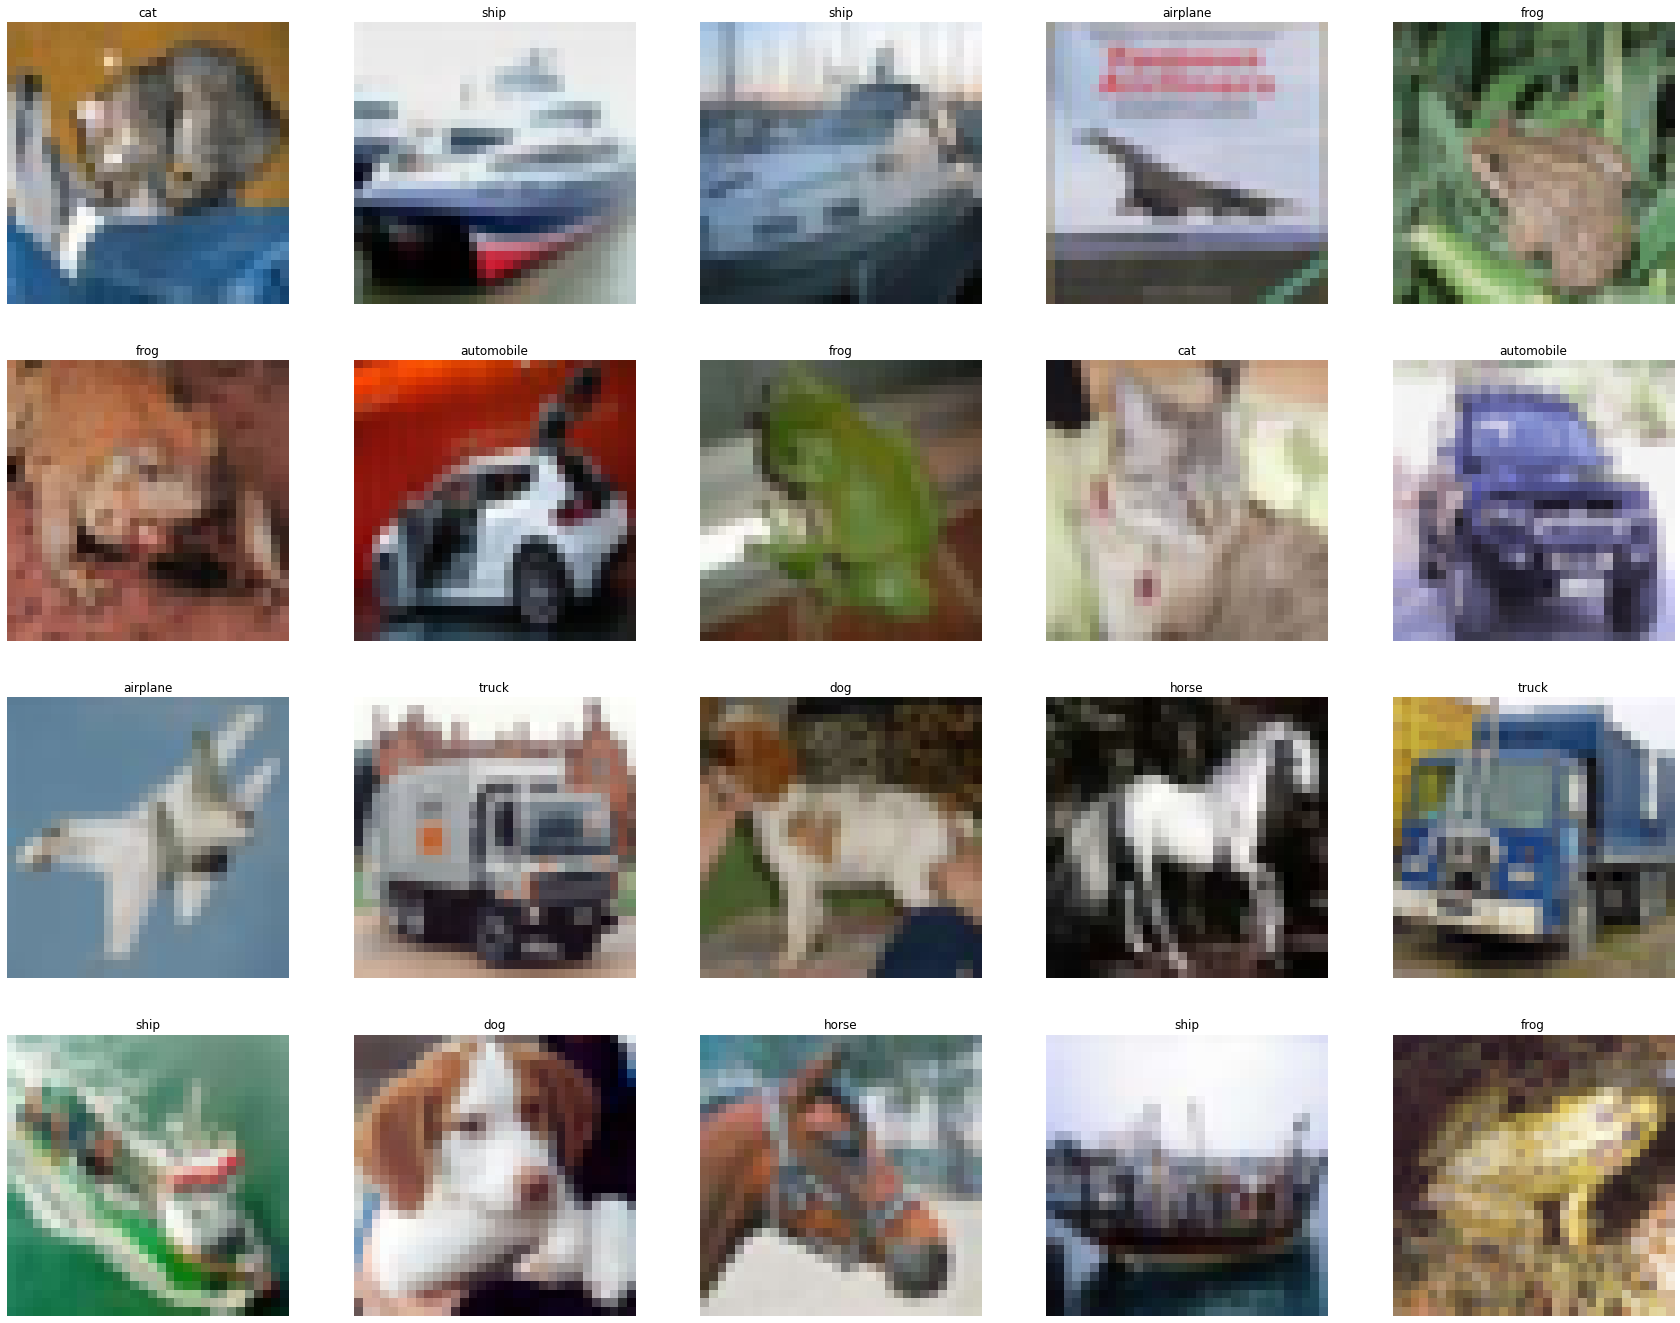

In [5]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(test_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [6]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

In [7]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


In [8]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [9]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')       
])

In [10]:
# param_number = output_channel_number * (input_channel_number * kernel_height * kernel_width + 1)

In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         5

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = " "
#with CPU :- 61
#0 :- 93.33
#with GPU :- 83

In [14]:
print("Num GPUs Available: ", tf.config.list_physical_devices())
tf.test.is_built_with_cuda()

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [15]:
history=model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/50
1562/1562 [==============================] - 71s 39ms/step - loss: 2.1159 - accuracy: 0.2614 - val_loss: 1.5943 - val_accuracy: 0.4289
Epoch 2/50
1562/1562 [==============================] - 65s 40ms/step - loss: 1.6887 - accuracy: 0.3927 - val_loss: 1.4182 - val_accuracy: 0.4869
Epoch 3/50
1562/1562 [==============================] - 60s 37ms/step - loss: 1.5142 - accuracy: 0.4545 - val_loss: 1.3180 - val_accuracy: 0.5222
Epoch 4/50
1562/1562 [==============================] - 68s 42ms/step - loss: 1.3871 - accuracy: 0.5021 - val_loss: 1.2121 - val_accuracy: 0.5699
Epoch 5/50
1562/1562 [==============================] - 86s 53ms/step - loss: 1.2945 - accuracy: 0.5387 - val_loss: 1.1516 - val_accuracy: 0.5917
Epoch 6/50
1562/1562 [==============================] - 78s 48ms/step - loss: 1.2031 - accuracy: 0.5719 - val_loss: 1.1086 - val_accuracy: 0.6037
Epoch 7/50
1562/1562 [==============================] - 96s 59ms/step - loss: 1.1319 - accuracy: 0.5976 - val_loss: 1.0458 -

In [16]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

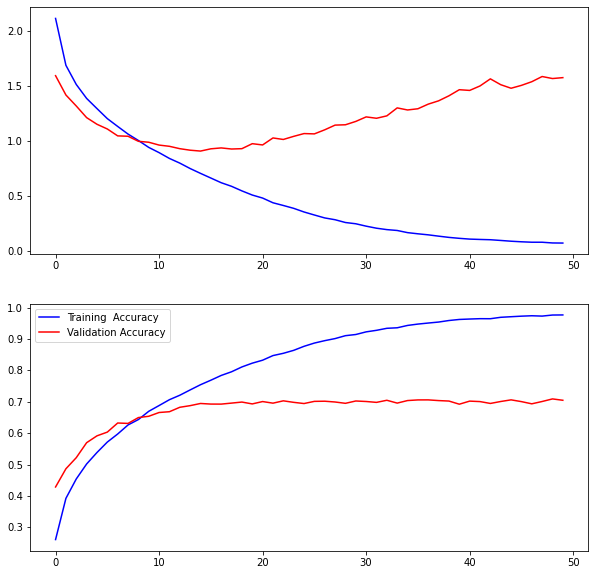

In [17]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [18]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.7093349099159241
